In [1]:
import geopandas
import pandas
import pathlib
import shapely
import numpy
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Split out different sections depending on the test dataset
### Small
Includes sections Section7, Section8, Section9, Section10

In [3]:
base_path = pathlib.Path(r"C:\Local\data\river_bathemetry\sections\Westport")

In [4]:
sections = geopandas.read_file(base_path / "river_outlines" / "small" / "measured_sections.geojson")
river_outlines = geopandas.read_file(base_path / "river_outlines" / "small" / "river_banks.geojson")

In [229]:
#riverbanks

# Explore Interpolation between sections
1. Create a centreline from the polygon
2. Create cross sections along the centreline
3. Estimate the Thalweg from the measued sections
4. Interpolate along points sampled along the lines

### 1. Create Centreline from briverbanks file
* Resample to the same number of nodes
* Explode into a row for each node
* Create a centreline (again same number of points)

In [230]:
# resample to the same number of points
n = 100
cross_sections = river_outlines.copy(deep=True)
cross_sections['geometry'] = cross_sections['geometry'].apply(lambda row: shapely.geometry.MultiPoint(row.interpolate(numpy.arange(0, 1 + 1/n, 1/n), normalized=True)))

In [231]:
cross_sections = cross_sections.explode(index_parts=True)
cross_sections = pandas.concat([cross_sections[cross_sections['Name']=='Right'].droplevel(0).geometry.rename('Right'), 
                                cross_sections[cross_sections['Name']=='Left'].droplevel(0).geometry.rename('Left')], axis = 1)
#cross_sections['Centre'] = cross_sections.apply(lambda row: shapely.geometry.MultiPoint([row['Right'], row['Left']]).centroid , axis=1)

### 2. Create cross sections along the centreline
* Calculate width
* Calculate the normal at each centreline point
* Create cross sections to width

In [247]:
'right' in cross_sections.columns

False

In [232]:
cross_sections['Cross Sections'] = cross_sections.apply(lambda row: shapely.geometry.LineString( [row['Right'], row['Left'] ] ), axis=1)

In [233]:
#cross_sections.set_geometry('Cross Sections', crs=crs)[['Cross Sections']].to_file(base_path /"river_outlines" / "small" / "cross_sections.geojson")

### 3. Estimate the Thalweg from the measued sections
* Clip measured sections to defined polygon
* Locate the Thalweg (minimum location) in each measured section & calculate the normalised lcoation
* Linearly interpolate the normalised Thalweg locations across the cross sections
* Insert nodes along each each cross section & explode out points
* Set the nearest cross section points to measured points to be the measured value then interpolate down river

In [234]:
# Clip measured sections within specified river outline
river_outlines_crs = river_outlines.crs
river_outlines.loc[3] = {"Name": "Polygon", "geometry": shapely.geometry.Polygon(numpy.append(river_outlines[river_outlines['Name']=='Right'].iloc[0].geometry.coords, river_outlines[river_outlines['Name']=='Left'].iloc[0].geometry.coords[::-1], axis=0))}
river_outlines.set_crs(river_outlines_crs, inplace=True);
sections = sections.clip(river_outlines[river_outlines["Name"]=="Polygon"]).sort_index()

Calculate the normalised thalweg location at each measured section and linearly interpolate across the cross sections

In [236]:
# Identify the thalweg location along each measured section
sections_exploded = sections.apply(lambda row: shapely.geometry.MultiPoint(row['geometry'].coords), axis=1).explode(index_parts=True)
thalweg_indices = sections_exploded.apply(lambda row: row.z).groupby(level=0).idxmin()
thalweg_indices
thalweg_points = sections_exploded[thalweg_indices]
thalweg_points

0  10    POINT Z (1483225.710 5375176.770 -5.153)
1  33    POINT Z (1483390.900 5374904.190 -2.173)
2  85    POINT Z (1483816.190 5374235.560 -1.933)
3  59    POINT Z (1483971.040 5373438.390 -2.553)
dtype: geometry

In [237]:
# Calculate the normalised thalweg location at each measured section
def calculate_normalised_thalweg_location(indices: tuple, sections_exploded):
    """ Tuple of the section index, and the point index along the section"""
    thalweg_point = sections_exploded[indices]
    left_bank_distance = thalweg_point.distance(sections_exploded.loc[indices[0]][0])
    right_bank_distance = thalweg_point.distance(sections_exploded.loc[indices[0]][len(sections_exploded.loc[indices[0]])-1])
    normalised_thalweg_location = left_bank_distance / (left_bank_distance + right_bank_distance)
    
    return normalised_thalweg_location

In [238]:
# Linearly interpolate the normalised Thalewg location along the cross sections 
cross_sections['Thalweg ratio'] = numpy.nan
cross_sections.loc[thalweg_indices.apply(lambda row: cross_sections['Cross Sections'].distance(thalweg_points[row]).idxmin()), 'Thalweg ratio'] = thalweg_indices.apply(lambda row: calculate_normalised_thalweg_location(row, sections_exploded)).array
cross_sections['Thalweg ratio'].interpolate(limit_direction='both', inplace=True)

## Explored two options for spacing points before setting up for interpolation
1. Equally spaced
2. Equally spaced on both sides of the Thalweg

In [239]:
n_nodes = 10

In [240]:
# Calculate the normalised thalweg location at each measured section
def split_line_to_nodes(line, thalweg_ratio, n_nodes = 20):
    """ Split line into n_nodes points half equally spaced on each side of the Thalweg"""
    normalised_node_locations = numpy.concatenate([numpy.arange(0, thalweg_ratio, thalweg_ratio/n_nodes),
                                                   numpy.arange(thalweg_ratio, 1 + (1-thalweg_ratio)/n_nodes, (1-thalweg_ratio)/n_nodes)])
    return shapely.geometry.MultiPoint(line.interpolate(normalised_node_locations, normalized=True))
cross_sections['Cross Sections'] = cross_sections[['Cross Sections', 'Thalweg ratio']].apply(lambda row: split_line_to_nodes(row['Cross Sections'], row['Thalweg ratio'], n_nodes=n_nodes), axis=1)

In [205]:
# Insert nodes along each cross section
normalised_node_locations = numpy.arange(0, 1 + 1.0/n_nodes, 1.0/n_nodes)
cross_sections['Cross Sections'] = cross_sections['Cross Sections'].apply(lambda line: shapely.geometry.MultiPoint(line.interpolate(normalised_node_locations, normalized=True)))

In [206]:
#cross_sections[['Cross Sections']].set_geometry('Cross Sections', crs=crs).to_file(base_path / "river_outlines" / "small" / "cross_section_points.geojson")

In [241]:
# Explode the cross sections
cross_sections_exploded = cross_sections[['Cross Sections']].set_geometry('Cross Sections', crs=crs).explode(index_parts=True)
nearest_cross_section_point_indices = sections_exploded.apply(lambda row: row.distance(cross_sections['Cross Sections'].explode(index_parts=True)).idxmin()).unique()

In [242]:
# Map the measured values to the nearest cross section and then linearly interpolate
cross_sections_exploded['z'] = numpy.nan
cross_sections_exploded.loc[nearest_cross_section_point_indices, 'z']  = cross_sections_exploded.loc[nearest_cross_section_point_indices, 'Cross Sections'].apply(lambda point: sections_exploded.loc[point.distance(sections_exploded).idxmin()].z)
cross_sections_exploded['z'] = cross_sections_exploded['z'].groupby(level=1, group_keys=False).apply(lambda group: group.interpolate(limit_direction='both'))

In [168]:
cross_sections_exploded.to_file(base_path / "river_outlines" / "small" / "cross_sections_with_z_equal.geojson")

<Axes: >

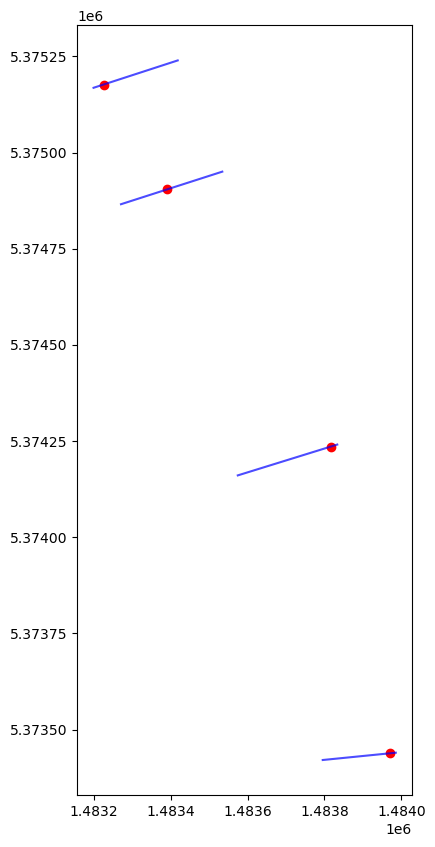

In [66]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
sections.plot(ax=ax, alpha=0.7, color="b")
thalweg_points.plot(ax=ax, color='r')

In [ ]:
thalweg_points = sections_exploded[sections_exploded.apply(lambda row: row.z).groupby(level=0).idxmin()]

# Complex cross section caluculation
* Looked at creating cross sections perpindicular to the centreline.
* Issues with the width not being the perpindidicular width
* Also started looking at intesecting the perpindicular cross sections to the right/left banks.
* Will need to extend the banks to ensure intersections at the start and end

In [ ]:
# Distance by numpy
import time
print("Compare shapely and numpy time")
start = time.time()
print(f"numpy max distance {numpy.max([numpy.sqrt((pt1.x - pt2.x)**2 + (pt1.y - pt2.y)**2) for (pt1, pt2) in zip(riverbanks['Right'], riverbanks['Left'])])}")
end = time.time()
print(f"time is {end - start}")
# Distance by shapely
start = time.time()
print(f"shapely time {numpy.max([pt1.distance(pt2) for (pt1, pt2) in zip(riverbanks['Right'], riverbanks['Left'])])}")
end = time.time()
print(end - start)
print("numpy is slower than shapely")

In [ ]:
def generate_cross_section(width, normal, centre):
    """ Create a line segment out from the centre point that defines the cross section """
    cross_section = shapely.geometry.LineString( [ [
                            centre.x - width / 2 * normal.x,
                            centre.y -  width / 2 * normal.y,
                        ], [
                            centre.x + width / 2 * normal.x,
                            centre.y +  width / 2 * normal.y,
                        ], ] )
    
    return cross_section

def generate_cross_section_3(width, normal, centre, right, left):
    """ Create a line segment out from the centre point that defines the cross section """
    cross_section = shapely.geometry.LineString( [ [
                            centre.x - width / 2 * normal.x,
                            centre.y -  width / 2 * normal.y,
                        ], [
                            centre.x + width / 2 * normal.x,
                            centre.y +  width / 2 * normal.y,
                        ], ] )
    
    #print(cross_section)
    #print(right)
    #print(left)
    print(cross_section.intersection(right))
    print(cross_section.intersection(left))
    cross_section = shapely.geometry.LineString( [ cross_section.intersection(right), cross_section.intersection(left) ] )
    #print(cross_section)
    return cross_section

def calculate_normal(index, centres):
    """ Calculate the slope along the centre points. try apply and smoothing for the 
    forward and backward segment and then combine as an average ignoring NaN"""
    if index == 0:
        # first segment - slope of next segment
        slope_normalised = calculate_segment_slope(centres.iloc[index], centres.iloc[index+1])
    elif index == len(centres) - 1:
        # last segment - slope of previous segment
        slope_normalised = calculate_segment_slope(centres.iloc[index-1], centres.iloc[index])
    else:
        # slope of the length weighted mean of both segments
        slope1_normalised = calculate_segment_slope(centres.iloc[index-1], centres.iloc[index])
        slope2_normalised = calculate_segment_slope(centres.iloc[index], centres.iloc[index+1])
        slope_normalised = normalise_segment(slope1_normalised, slope2_normalised)
    normal_normalised = shapely.geometry.Point([-slope_normalised.y, slope_normalised.x]) 

    return normal_normalised

def calculate_segment_slope(pt1, pt2):
    """ Calculate the slope along the centre points. try apply and smoothing for the 
    forward and backward segment and then combine as an average ignoring NaN"""
    length = pt1.distance(pt2)
    segment_slope_normalised = shapely.geometry.Point([(pt1.x-pt2.x)/length, (pt1.y-pt2.y)/length])
    return segment_slope_normalised

def normalise_segment(pt1, pt2):
    """ Calculate the slope along the centre points. try apply and smoothing for the 
    forward and backward segment and then combine as an average ignoring NaN"""
    length = numpy.sqrt((pt1.x + pt2.x) ** 2 + (pt1.y + pt2.y) ** 2)
    segment_normalised = shapely.geometry.Point([(pt1.x + pt2.x)/length, (pt1.y + pt2.y)/length])
    return segment_normalised

In [ ]:
riverbank_lines = geopandas.read_file(base_path / "river_outlines" / "small" / "river_banks.geojson")

In [ ]:
max_width = numpy.max([pt1.distance(pt2) for (pt1, pt2) in zip(riverbanks['Right'], riverbanks['Left'])])
riverbanks["Width"] = riverbanks.apply(lambda row: row['Left'].distance(row['Right']), axis=1)
riverbanks['Normal'] = riverbanks.apply(lambda row: calculate_normal(row.name, riverbanks['Centre']), axis=1)
riverbanks['Cross Sections'] = riverbanks.apply(lambda row: generate_cross_section(width=max_width, normal=row['Normal'], centre=row['Centre']), axis=1) #row['Width']

In [ ]:
print(riverbanks['Cross Sections'].loc[0].intersection(riverbank_lines.loc[0].geometry))

In [ ]:
riverbanks.head(3)

In [ ]:
riverbanks.set_geometry('Cross Sections', crs=crs)[['Cross Sections']].to_file(base_path /"river_outlines" / "small" / "cross_sections.geojson")
riverbanks.set_geometry('Centre', crs=crs)[['Centre']].to_file(base_path /"river_outlines" / "small" / "centre.geojson")

In [ ]:
pt1 = riverbanks['centre'].iloc[0]; pt2 = riverbanks['centre'].iloc[1]

In [ ]:
length = pt1.distance(pt2) # numpy.sqrt((pt1.x - pt2.x) ** 2 + (pt1.y - pt2.y) ** 2)
dpt = shapely.affinity.scale((pt1 - pt2), xfact=1.0/length, yfact=1.0/length)

In [ ]:
print("Compare normal time")
start = time.time()
riverbanks.apply(lambda row: calculate_normal(row.name, riverbanks['centre']), axis=1)
end = time.time()
print(f"time is {end - start}")

In [ ]:
def _segment_slope(x_array, y_array, index):
    """Return the slope and length characteristics of a line segment.

    Parameters
    ----------

    x_array
        The x values of all polyline nodes.
    y_array
        The y values of all polyline nodes.
    index
        The segment index (the index of the starting node in the segment)
    """
    length = numpy.sqrt(
        (x_array[index + 1] - x_array[index]) ** 2
        + (y_array[index + 1] - y_array[index]) ** 2
    )
    dx = (x_array[index + 1] - x_array[index]) / length
    dy = (y_array[index + 1] - y_array[index]) / length
    return dx, dy, length

In [ ]:
# Set width of each 
centrelines = {"widths": [], "cross sections": []}
for (pt1, pt2) in zip(riverbanks.iloc[0].geometry.coords, riverbanks.iloc[1].geometry.coords):
    centrelines["widths"].append(numpy.max([numpy.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)]))
    # Calculate perpindiculars ato 
    centrelines["cross sections"].append(shapely.geometry.LineString([[] for i in range(n+1)]))
    

In [ ]:
# Set width of each 
centrelines = {"widths": [], "cross sections": []}
(x_array, y_array) = riverbanks.iloc[2].geometry.xy
for index, (pt1, pt2) in enumerate(zip(riverbanks.iloc[0].geometry.coords, riverbanks.iloc[1].geometry.coords)):
    centrelines["widths"].append(numpy.max([numpy.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)]))
    # Calculate perpindiculars ato 
    #centrelines["cross sections"].append(shapely.geometry.LineString([[] for i in range(n+1)]))
    if index == 0:
        # first segment - slope of next segment
        dx, dy, length = _segment_slope(x_array, y_array, index)
    elif index == len(x_array) - 1:
        # last segment - slope of previous segment
        dx, dy, length = _segment_slope(x_array, y_array, index - 1)
    else:
        # slope of the length weighted mean of both segments
        dx_prev, dy_prev, l_prev = _segment_slope(x_array, y_array, index)
        dx_next, dy_next, l_next = _segment_slope(x_array, y_array, index - 1)
        dx = (dx_prev * l_prev + dx_next * l_next) / (l_prev + l_next)
        dy = (dy_prev * l_prev + dy_next * l_next) / (l_prev + l_next)
        length = (l_prev + l_next) / 2
    normal_x = -dy
    normal_y = dx
    cross_sections_dict["geometry"].append(
                shapely.geometry.LineString(
                    [
                        [
                            x_array[i] - self.transect_radius * normal_x,
                            y_array[i] - self.transect_radius * normal_y,
                        ],
                        [x_array[i], y_array[i]],
                        [
                            x_array[i] + self.transect_radius * normal_x,
                            y_array[i] + self.transect_radius * normal_y,
                        ],
                    ]
                )
            )
    centrelines["cross sections"].append(shapely.geometry.LineString([[] for i in range(n+1)]))

In [ ]:
if i == 0:
                # first segment - slope of next segment
                dx, dy, length = self._segment_slope(x_array, y_array, i)
            elif i == len(x_array) - 1:
                # last segment - slope of previous segment
                dx, dy, length = self._segment_slope(x_array, y_array, i - 1)
            else:
                # slope of the length weighted mean of both segments
                dx_prev, dy_prev, l_prev = self._segment_slope(x_array, y_array, i)
                dx_next, dy_next, l_next = self._segment_slope(x_array, y_array, i - 1)
                dx = (dx_prev * l_prev + dx_next * l_next) / (l_prev + l_next)
                dy = (dy_prev * l_prev + dy_next * l_next) / (l_prev + l_next)
                length = (l_prev + l_next) / 2
            normal_x = -dy
            normal_y = dx

In [ ]:
centrelines["widths"]

# debug geofabrics

In [ ]:
cache_path = pathlib.Path(r"C:\Local\data\catchments\Westport\caches\NZ20_Westport")
folder = "paper"
channel = geopandas.read_file(cache_path / folder / "wide_river" / "network_river_centreline_6308000000_smoothed.geojson")

In [ ]:
channel2 = geopandas.read_file(cache_path / folder / "wide_river" / "aligned_river_centreline_6308000000.geojson")

In [ ]:
geopandas.read_file(r"C:\Local\repos\GeoFabrics\tests\test_river_bathymetry_osm_wellington\data\

In [ ]:
n=geopandas.read_file(r"C:\Local\repos\GeoFabrics\tests\test_river_bathymetry_osm_wellington\data\rec1_flow_and_friction.geojson").to_crs(crs)

In [ ]:
crs

In [ ]:
n

In [ ]:
channel.rotate(45).plot()

In [ ]:
channel.rotate(45).boundary.plot()